In [ ]:
import time
import matplotlib.pyplot as plt
import random

In [ ]:
def generate_random_sequence(length):
    return ''.join(random.choice('ACGT') for _ in range(length))

In [ ]:
def smith_waterman(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-2):
    rows = len(seq1) + 1
    cols = len(seq2) + 1

    score_matrix = [[0 for j in range(cols)] for i in range(rows)]
    traceback_matrix = [[0 for j in range(cols)] for i in range(rows)]

    max_score = 0
    max_pos = None
    for i in range(1, rows):
        for j in range(1, cols):
            score = 0
            if seq1[i-1] == seq2[j-1]:
                match = score_matrix[i-1][j-1] + match_score
            else:
                match = score_matrix[i-1][j-1] + mismatch_score

            delete = score_matrix[i-1][j] + gap_penalty
            insert = score_matrix[i][j-1] + gap_penalty
            score = max(0, match, delete, insert)

            if score > max_score:
                max_score = score
                max_pos = (i, j)

            score_matrix[i][j] = score

            if score == 0:
                traceback_matrix[i][j] = 0
            elif score == match:
                traceback_matrix[i][j] = 1
            elif score == insert:
                traceback_matrix[i][j] = 2
            else:
                traceback_matrix[i][j] = 3

    align1 = []
    align2 = []
    i, j = max_pos
    while traceback_matrix[i][j] != 0:
        if traceback_matrix[i][j] == 1:
            align1.append(seq1[i-1])
            align2.append(seq2[j-1])
            i -= 1
            j -= 1
        elif traceback_matrix[i][j] == 2:
            align1.append('-')
            align2.append(seq2[j-1])
            j -= 1
        else:
            align1.append(seq1[i-1])
            align2.append('-')
            i -= 1

    align1.reverse()
    align2.reverse()

    return max_score, (''.join(align1), ''.join(align2))

In [ ]:
def modified_local_alignment(seq1, seq2, sim_matrix, gap_penalty):
    rows = len(seq1) + 1
    cols = len(seq2) + 1

    score_matrix = [[0 for j in range(cols)] for i in range(rows)]
    traceback_matrix = [[0 for j in range(cols)] for i in range(rows)]

    max_score = 0
    max_pos = None
    for i in range(1, rows):
        for j in range(1, cols):
            score = 0
            match = score_matrix[i-1][j-1] + sim_matrix.get((seq1[i-1], seq2[j-1]), 0)

            gap_row = [score_matrix[i-k][j] - gap_penalty(k) for k in range(1, i+1)]
            gap_col = [score_matrix[i][j-l] - gap_penalty(l) for l in range(1, j+1)]

            delete = max(gap_row + [0])
            insert = max(gap_col + [0])

            score = max(0, match, delete, insert)

            if score > max_score:
                max_score = score
                max_pos = (i, j)

            score_matrix[i][j] = score

            if score == 0:
                traceback_matrix[i][j] = 0
            elif score == match:
                traceback_matrix[i][j] = 1
            elif score == insert:
                traceback_matrix[i][j] = 2
            else:
                traceback_matrix[i][j] = 3

    align1 = []
    align2 = []
    i, j = max_pos
    while traceback_matrix[i][j] != 0:
        if traceback_matrix[i][j] == 1:
            align1.append(seq1[i-1])
            align2.append(seq2[j-1])
            i -= 1
            j -= 1
        elif traceback_matrix[i][j] == 2:
            align1.append('-')
            align2.append(seq2[j-1])
            j -= 1
        else:
            align1.append(seq1[i-1])
            align2.append('-')
            i -= 1

    align1.reverse()
    align2.reverse()

    return max_score, (''.join(align1), ''.join(align2))

In [ ]:
def compare_algorithms(lengths, sim_matrix, gap_penalty):
    smith_waterman_scores = []
    smith_waterman_times = []
    modified_local_alignment_scores = []
    modified_local_alignment_times = []

    for length in lengths:
        seq1 = generate_random_sequence(length)
        seq2 = generate_random_sequence(length)

        start_time = time.time()
        sw_score, sw_alignment = smith_waterman(seq1, seq2)
        sw_time = time.time() - start_time
        smith_waterman_scores.append(sw_score)
        smith_waterman_times.append(sw_time)
        print(f"Smith-Waterman for length {length}: Score = {sw_score}, Alignment = {sw_alignment}")

        start_time = time.time()
        mla_score, mla_alignment = modified_local_alignment(seq1, seq2, sim_matrix, gap_penalty)
        mla_time = time.time() - start_time
        modified_local_alignment_scores.append(mla_score)
        modified_local_alignment_times.append(mla_time)
        print(f"Modified Local Alignment for length {length}: Score = {mla_score}, Alignment = {mla_alignment}")

    return (smith_waterman_scores, smith_waterman_times,
            modified_local_alignment_scores, modified_local_alignment_times)

lengths = [100,200]

sim_matrix = {
    ('A', 'A'): 1, ('A', 'C'): -1, ('A', 'G'): -1, ('A', 'T'): -1,
    ('C', 'A'): -1, ('C', 'C'): 1, ('C', 'G'): -1, ('C', 'T'): -1,
    ('G', 'A'): -1, ('G', 'C'): -1, ('G', 'G'): 1, ('G', 'T'): -1,
    ('T', 'A'): -1, ('T', 'C'): -1, ('T', 'G'): -1, ('T', 'T'): 1
}

def gap_penalty(k):
    return k

sw_scores, sw_times, mla_scores, mla_times = compare_algorithms(lengths, sim_matrix, gap_penalty)

Smith-Waterman for length 50: Score = 7, Alignment = ('CCTATTCTGGTC', 'CCTAGT-TGGTC')
Modified Local Alignment for length 50: Score = 9, Alignment = ('GCCTATTCTGGTCGCTCGTTACA', 'GCC-CTTC-GGTTGCCCG--ACA')
Smith-Waterman for length 100: Score = 8, Alignment = ('CTGCCAG-TGACGGT', 'CTGGCAGATCACGGT')
Modified Local Alignment for length 100: Score = 14, Alignment = ('AGC--AG-CA-C-TTATAG-AC-TTGAGACAAAT-ACCTTCAACGGCTTAAT-TG--T-CTGCCAG-TGACGGTAATTCGAAATCC-A-CCG', 'AGCTGAGCCACCGGTA-AGCACGTT---TCCAATGAGGGAC-AC-G--TACTGTGCCTGCTGGCAGATCACGGT--GTCG---TCCTAGCCG')
Smith-Waterman for length 150: Score = 9, Alignment = ('GACAT--TTCAAAAGATATTGTG-CAGATCTTGG', 'GACATCCTGCAAACCAAATTGGGTCAGTACGTGG')
Modified Local Alignment for length 150: Score = 16, Alignment = ('TGTGCAGATC--TTGGT-TCGCGTGGTGTGCCA-GG-AAG-CCTGTGGTGTTTTAG-C-TCATAAGC-GATC-AAGTGCGCCAAGAGGTACG-AGCTAATGGT-A-CC--TGATGTTCGCTGGTGA', 'TG-GCAGACCGACCGGTAT--CGT--TG-ACAACGGAAAGTAAAGCGGT-TTGT-GACATCCT--GCAAACCAAATTGGGTC---A-GTACGTGGCGAATACTAACCCATTGAACCT

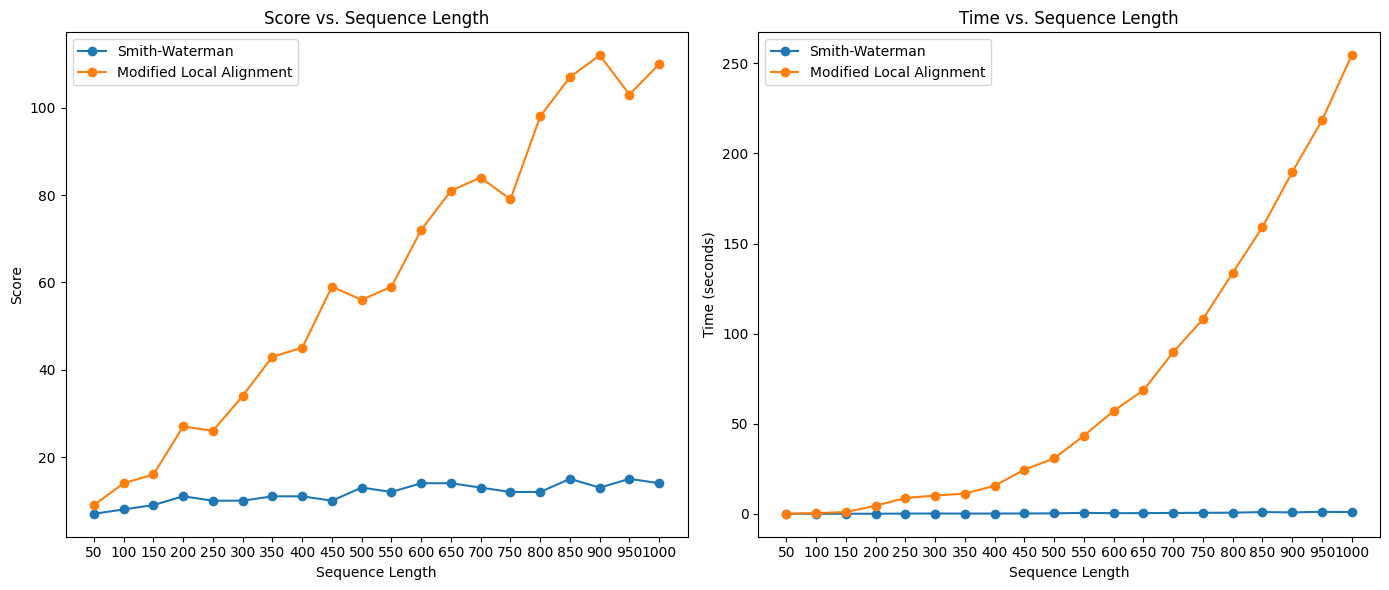

In [ ]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lengths, sw_scores, marker='o', label='Smith-Waterman')
plt.plot(lengths, mla_scores, marker='o', label='Modified Local Alignment')
plt.xlabel('Sequence Length')
plt.ylabel('Score')
plt.title('Score vs. Sequence Length')
plt.xticks(lengths)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lengths, sw_times, marker='o', label='Smith-Waterman')
plt.plot(lengths, mla_times, marker='o', label='Modified Local Alignment')
plt.xlabel('Sequence Length')
plt.ylabel('Time (seconds)')
plt.title('Time vs. Sequence Length')
plt.xticks(lengths)
plt.legend()

plt.tight_layout()
plt.show()